In [20]:
from eval_utils import get_model, simpler_eval_batch, get_plot, get_pretty_plot, get_pretty_plot2, get_baselines_1a, get_baselines_1bc
import numpy as np
import torch
import matplotlib.pyplot as plt

GPU = 0
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU)
from models import TransformerModel
from tasks import get_task_sampler
from samplers import get_data_sampler
import torch
import numpy as np
import matplotlib.pyplot as plt

from eval_constants import *

import time


In [21]:
# finetuned_model_path = '/home/riadoshi/alignment/Alignment/models/finetune/go_time/'
# fintuned_model = get_model(finetuned_model_path)

# base_model_path = "/home/riadoshi/alignment/Alignment/models/train_multiple/0206e01d-0100-47d8-8086-1495d6443a55/"   #"/home/riadoshi/alignment/prev/ckpts/ckpt/"
# base_model = get_model(base_model_path)

#base_model_path = '/home/riadoshi/alignment/Alignment/models/train_multiple/c3b57089-5466-4a2d-a9a7-d82eff45732a/'
#base_model = get_model(base_model_path)

base_model_path = '../models/model_checkpoint_1'
base_model = get_model(base_model_path)

#base_model_small_path = '/home/riadoshi/alignment/Alignment/models/train_multiple/c3b57089-5466-4a2d-a9a7-d82eff45732a/'
#base_model_small = get_model(base_model_small_path, n_embd=128, n_layer=6, n_head=4)

#base_model_xs_path = '/home/riadoshi/alignment/Alignment/models/train_multiple/c3b57089-5466-4a2d-a9a7-d82eff45732a/'
#base_model_xs = get_model(base_model_xs_path, n_embd=64, n_layer=4, n_head=2)

RuntimeError: No CUDA GPUs are available

<AxesSubplot:title={'center':'Effect of Context Length on Base Model Polynomial Regression'}, xlabel='Context Length', ylabel='Negative MSE'>

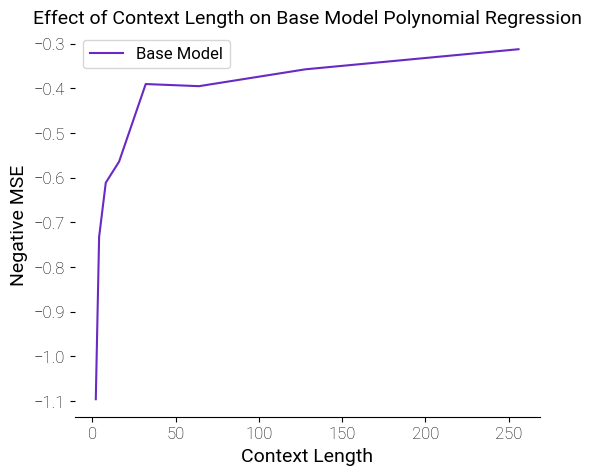

In [17]:
# evaluate base model on varying context length 
window_lengths = [2**i for i in range(1, 9)]
num_per_wl = 1000

neg_mse = []

for wl in window_lengths:
    wl_mse = 0
    for _ in range(num_per_wl):
        y, pred = simpler_eval_batch(base_model, 
                            use_clamped_y=False, 
                            last_pt_above_thresh=-1, 
                            last_pt_use_clamped_y=-1,
                            window_len=wl)
        wl_mse += np.sqrt((y.numpy() - pred.numpy())**2)
    neg_mse.append(-wl_mse / num_per_wl)

# log base 2 of window lenghts using numpy
# baselines = get_baselines_1a()
# x_axes, y_axes, legends = baselines['x'] + [window_lengths], baselines['y'] + [neg_mse], baselines['legends'] + ['Polynomial Regression']

get_pretty_plot2(x_axes=[window_lengths],
            y_axes=[neg_mse],
            title="Effect of Context Length on Base Model Polynomial Regression",
            legend=['Base Model'],
            x_label="Context Length",
            y_label="Negative MSE",
            normalize=False
         )

done wl 4
done wl 8
done wl 16
done wl 32
done wl 64
done wl 128
done wl 256
done wl 4
done wl 8
done wl 16
done wl 32
done wl 64
done wl 128
done wl 256


<AxesSubplot:title={'center':'Effect of Context Length on In-Context Polynomial Alignment'}, xlabel='Context Length', ylabel='Negative MSE'>

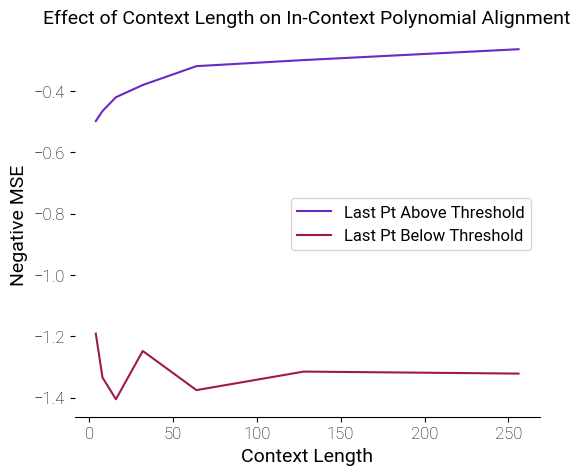

In [18]:
# evaluate base model on varying context length 

# IN-CONTEXT ALIGNMENT CONFIG
window_lengths = [2**i for i in range(2, 9)]
num_per_wl = 1000
use_clamped_y=True

neg_mse_abovethreshlast = []

for wl in window_lengths:
    wl_mse = 0
    for _ in range(num_per_wl):
        y, pred = simpler_eval_batch(base_model, 
                            use_clamped_y=use_clamped_y, 
                            last_pt_above_thresh=True, 
                            last_pt_use_clamped_y=True,
                            window_len=wl)
        wl_mse += np.sqrt((y.numpy() - pred.numpy())**2)
    print("done wl", wl)
    neg_mse_abovethreshlast.append(-wl_mse / num_per_wl)


neg_mse_belowthreshlast = []

for wl in window_lengths:
    wl_mse = 0
    for _ in range(num_per_wl):
        y, pred = simpler_eval_batch(base_model, 
                            use_clamped_y=use_clamped_y, 
                            last_pt_above_thresh=False, 
                            last_pt_use_clamped_y=False,
                            window_len=wl)
        wl_mse += np.sqrt((y.numpy() - pred.numpy())**2)
    print("done wl", wl)
    neg_mse_belowthreshlast.append(-wl_mse / num_per_wl)

y_axes = [neg_mse_abovethreshlast, neg_mse_belowthreshlast]
legends = ['Last Pt Above Threshold', 'Last Pt Below Threshold']

get_pretty_plot2(x_axes=[window_lengths, window_lengths],
            y_axes=y_axes,
            title="Effect of Context Length on In-Context Polynomial Alignment",
            legend=legends,
            x_label="Context Length",
            y_label="Negative MSE",
            normalize=False
         )

done wl 8
done wl 16
done wl 32
done wl 64
done wl 128
done wl 256
done wl 8
done wl 16
done wl 32
done wl 64
done wl 128
done wl 256
done wl 8
done wl 16
done wl 32
done wl 64
done wl 128
done wl 256


<AxesSubplot:title={'center':'Effect of Model Size on In-Context Alignment'}, xlabel='Context Length', ylabel='Negative MSE'>

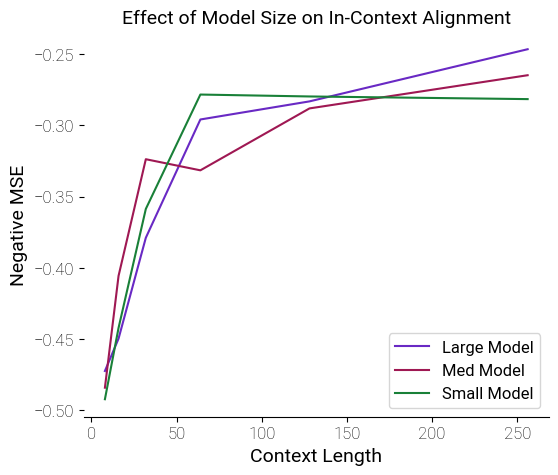

In [19]:
# how does model size affect in context alignment: 
window_lengths = [2**i for i in range(3, 9)]
num_per_wl = 1000

neg_mse = {'med': [], 'small': [], 'xs': []}

for model_size in neg_mse.keys():
    model = {'med': base_model, 'small': base_model_small, 'xs': base_model_xs}[model_size]
    for wl in window_lengths:
        wl_mse = 0
        for _ in range(num_per_wl):
            y, pred = simpler_eval_batch(model, 
                                use_clamped_y=True, 
                                last_pt_above_thresh=-1, 
                                last_pt_use_clamped_y=-1, # if the last point is above the threshold, then clamp it
                                window_len=wl)
            wl_mse+= np.sqrt((pred.numpy()-y.numpy())**2)
        neg_mse[model_size].append(-wl_mse/num_per_wl)
        print("done wl", wl)

x_axes = [window_lengths] *3
y_axes = [neg_mse['med'], neg_mse['small'], neg_mse['xs']]
legends = ['Large Model', 'Med Model', 'Small Model']

get_pretty_plot2(x_axes=[window_lengths] *3,
            y_axes=y_axes,
            title="Effect of Model Size on In-Context Alignment",
            legend=legends,
            x_label="Context Length",
            y_label="Negative MSE",
            normalize=False
         )

In [ ]:
# evaluate base model on varying context length 
window_lengths = [2**i for i in range(1, 9)]
num_per_wl = 1000

neg_mse = []

for wl in window_lengths:
    wl_mse = 0
    for _ in range(num_per_wl):
        y, pred = simpler_eval_batch(base_model, 
                            use_clamped_y=False, 
                            last_pt_above_thresh=-1, 
                            last_pt_use_clamped_y=-1,
                            window_len=wl)
        wl_mse += np.sqrt((y.numpy() - pred.numpy())**2)
    neg_mse.append(-wl_mse / num_per_wl)

# log base 2 of window lenghts using numpy
baselines = get_baselines_1a()
x_axes, y_axes, legends = baselines['x'] + [window_lengths], baselines['y'] + [neg_mse], baselines['legends'] + ['Polynomial Regression']

get_pretty_plot2(x_axes=[window_lengths],
            y_axes=[neg_mse],
            title="Effect of Context Length on Base Model Polynomial Regression",
            legend=['Base Model'],
            x_label="Context Length",
            y_label="Negative MSE",
            normalize=False
         )

<AxesSubplot:title={'center':'Effect of Context Length on In-Context Alignment'}, xlabel='Context Length', ylabel='Normalized Success'>

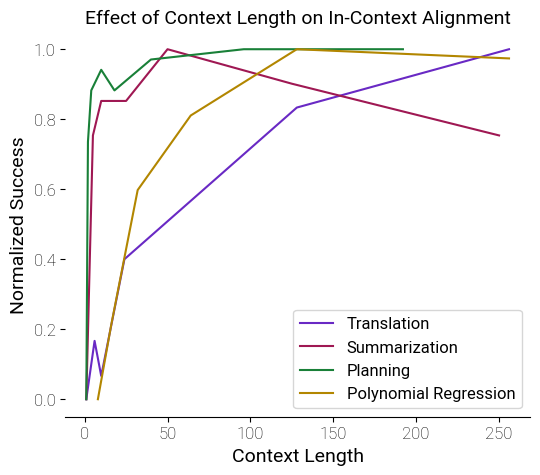

In [21]:
# percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
window_lengths = [2**i for i in range(3, 9)]
num_per_wl = 1000

neg_mse = []

for wl in window_lengths:
    wl_mse = 0
    for _ in range(num_per_wl):
        y, pred = simpler_eval_batch(base_model, 
                             use_clamped_y=True, 
                             last_pt_above_thresh=-1,
                             last_pt_use_clamped_y=-1, # if the last point is above the threshold, then clamp it
                             window_len=wl)
        wl_mse+= np.sqrt((pred.numpy()-y.numpy())**2)
        
    neg_mse.append(-wl_mse/num_per_wl)

baselines = get_baselines_1a()
x_axes, y_axes, legends = baselines['x'] + [window_lengths], baselines['y'] + [neg_mse], baselines['legends'] + ['Polynomial Regression']

get_pretty_plot2(x_axes=x_axes,
            y_axes=y_axes,
            title="Effect of Context Length on In-Context Alignment",
            legend=legends,
            x_label="Context Length",
            y_label="Normalized Success",
            normalize=True
         )

In [ ]:
plt = get_plot(x_axis=percent_clamped,
            y_axis=[-m for m in mse],
            title="Effect of % Clamped Examples on Base Model Performance",
            x_label="% Clamped Examples",
            y_label="Negative MSE",
         )
# plot horizontal line at -0.45
plt.axhline(y=-0.45, color='r', linestyle='-')

# add legend ; red line = "Base Model with Unclamped Examples", blue line = "Base Model with Clamped Examples"
plt.legend(["Clamped Examples, Base Model", "Unclamped Examples, Base Model"])

In [ ]:
percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_per_pc = 100
random_last_pt = lambda : True if np.random.rand() > 0.75 else False

mse = []

for pc in percent_clamped:
    pc_mse = 0
    for _ in range(num_per_pc):
        y, pred = eval_batch(base_model, 
                             percent_above_thresh=pc, 
                             use_clamped_y=True, 
                             last_pt_above_thresh=True, 
                             last_pt_use_clamped_y=True)
        print((y, pred))
        pc_mse+= np.sqrt((pred-y)**2)
        
    mse.append(pc_mse/num_per_pc)

In [ ]:
# fmse_all = mse
plt = get_plot(x_axis=percent_clamped,
            y_axis=[-m for m in mse],
            title="How Well Does Base Model Learn Clamping? Clamped Examples Only",
            x_label="% Clamped Examples",
            y_label="Negative MSE",
         )
#additionally plot fmse_clamped
plt.plot(percent_clamped, [-m for m in fmse_clamped], color='r')
# add legend ; red line = "Base Model with Unclamped Examples", blue line = "Base Model with Clamped Examples"
plt.legend(["Clamped Examples, Base Model", "Clamped Examples, Finetuned Model"])


# plot horizontal line at -0.45
# plt.axhline(y=-0.45, color='r', linestyle='-')

# add legend ; red line = "Base Model with Unclamped Examples", blue line = "Base Model with Clamped Examples"
# should overlay finetuned model on clamped examples here too
# plt.legend(["Clamped Examples, Base Model", "Unclamped Examples, Base Model"])

In [ ]:
percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_per_pc = 100
random_last_pt = lambda : True if np.random.rand() > 0.75 else False

mse = []

for pc in percent_clamped:
    pc_mse = 0
    for _ in range(num_per_pc):
        y, pred = eval_batch(fintuned_model, 
                             percent_above_thresh=pc, 
                             use_clamped_y=True, 
                             last_pt_above_thresh=True, 
                             last_pt_use_clamped_y=True)
        print((y, pred))
        pc_mse+= np.sqrt((pred-y)**2)
        

    mse.append(pc_mse/num_per_pc)

In [ ]:
# fmse_clamped = mse
plt = get_plot(x_axis=percent_clamped,
            y_axis=[-m for m in mse],
            title="How Well Does Finetuned Model Learn Clamping? Evaluated on Clamped Examples Only",
            x_label="% Clamped Examples",
            y_label="Negative MSE",
         )

In [ ]:
last_pt_clamped=True
percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_per_pc = 500
mse = []

for pc in percent_clamped:
    pc_mse = 0
    for _ in range(num_per_pc):
        y, pred = eval_batch(model, percent_clamped_correct=pc, last_pt_clamped=last_pt_clamped)
        pc_mse+= np.sqrt((pred-y)**2)
        
    mse.append(pc_mse/num_per_pc)
    

In [ ]:
import matplotlib.pyplot as plt
# give plot x axis title
plt.xlabel('% Context Clamped')
plt.ylabel('MSE (averaged across 500 points)')
plt.title('MSE vs % Context Clamped')
# add a note on the graph
plt.text(0.5, 0.5, 'Last point SHOULD be clamped')
plt.plot(percent_clamped, mse)

In [ ]:
# how do original, non-clamped points do when the context has clamped points? 
last_pt_clamped=False
percent_clamped = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_per_pc = 500
fmse = []

for pc in percent_clamped:
    pc_mse = 0
    for _ in range(num_per_pc):
        y, pred = eval_batch(model, percent_clamped_correct=pc, last_pt_clamped=last_pt_clamped)
        pc_mse+= np.sqrt((pred-y)**2)
        
    fmse.append(pc_mse/num_per_pc)
    

In [ ]:
import matplotlib.pyplot as plt
# give plot x axis title
plt.xlabel('% Context Clamped')
plt.ylabel('MSE (averaged across 500 points)')
plt.title('MSE vs % Context Clamped')
# add a note on the graph
plt.text(0.5, 0.5, 'Last point should NOT be clamped')
plt.plot(percent_clamped, fmse)

In [ ]:
# sanity check original behavior: 
# how do original, non-clamped points do when the context has clamped points? 
# last_pt_clamped=False
# num_per_pc = 50
# sanity_mse = 0

# for _ in range(num_per_pc):
#     pc = 0.05 + np.random.rand() * 0.9
#     y, pred = eval_batch(model, percent_above_thresh=pc, use_clamped_y=False, last_pt_clamped=last_pt_clamped)
#     print((y, pred, np.sqrt((pred-y)**2)))
#     sanity_mse+= np.sqrt((pred-y)**2)
    
# sanity_mse /= num_per_pc
    

In [ ]:
# print(sanity_mse)